<a href="https://colab.research.google.com/github/Mathvivas/Artificial-Intelligence/blob/main/MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

In [2]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


I used ToTensor to transform the data into tensors and Normalize with 0.5 to make values range from -1 to 1. Since the data is black and white, I only use only (0.5,).

## Explore the Dataset

In [3]:
## Showing 5 images from a dataloader
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


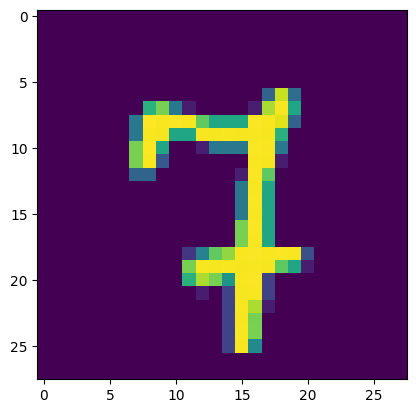

2


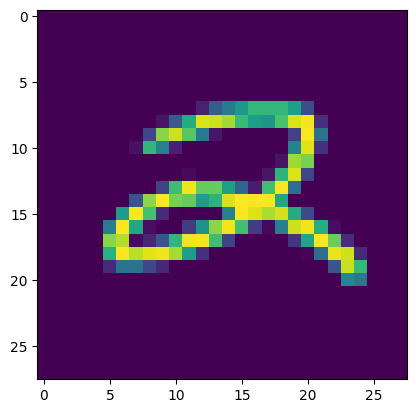

1


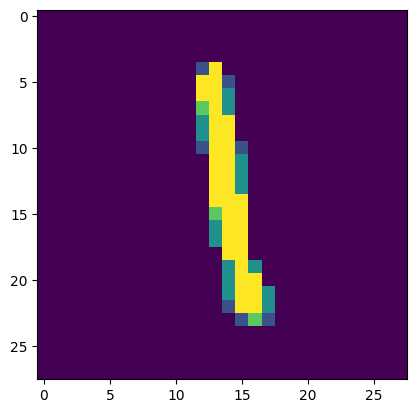

8


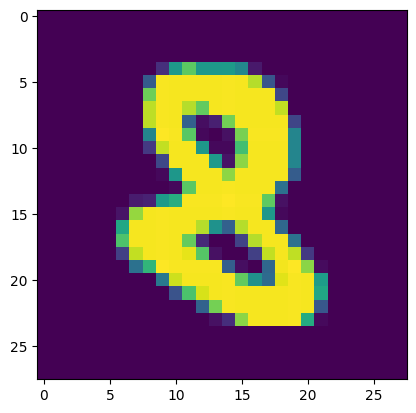

3


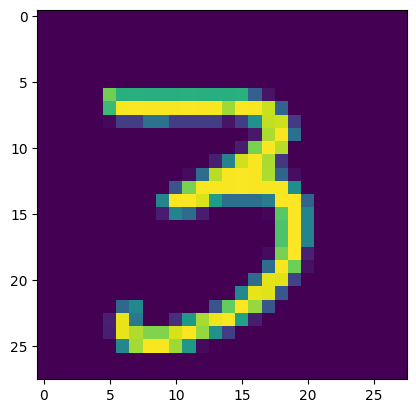

In [4]:
# Explore data
show5(train_dataloader)

## Build your Neural Network

In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

6000x1x28x28 (Batch, RGB, height, width)

$n_{out} = |\frac{n_{in}+2p-k}{s}| + 1$

$n_{in}$: input features <br>
$n_{out}$: output features <br>
k: kernel size <br>
p: padding size <br>
s: stride size

$n_{out} = |\frac{28+2*1-3}{1}| + 1$ <br>
$n_{out} = 28$

- After 2x AvgPool2d: $n_{out} = 7$

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input channel(grayscale), 16 output channels, 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # 16 input channels, 32 output channels, 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 392)
        self.fc2 = nn.Linear(392, 10)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network

In [8]:
epochs = 10
loss_values = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass and optimization
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate Accuracy
        _, predicted = torch.max(outputs.data, 1) # Getting the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

        # Calculate average loss and accuracy
        average_loss = train_loss / len(train_dataloader)
        accuracy = 100 * correct / total

    loss_values.append(train_loss / len(train_dataloader))
    print(f'Epoch {epoch + 1} - training accuracy: {accuracy:.2f}% training loss: {average_loss:.5f}')

Epoch 1 - training accuracy: 93.31% training loss: 0.22453
Epoch 2 - training accuracy: 98.17% training loss: 0.06041
Epoch 3 - training accuracy: 98.70% training loss: 0.04194
Epoch 4 - training accuracy: 98.97% training loss: 0.03237
Epoch 5 - training accuracy: 99.20% training loss: 0.02496
Epoch 6 - training accuracy: 99.37% training loss: 0.01995
Epoch 7 - training accuracy: 99.47% training loss: 0.01691
Epoch 8 - training accuracy: 99.55% training loss: 0.01460
Epoch 9 - training accuracy: 99.60% training loss: 0.01202
Epoch 10 - training accuracy: 99.68% training loss: 0.00969


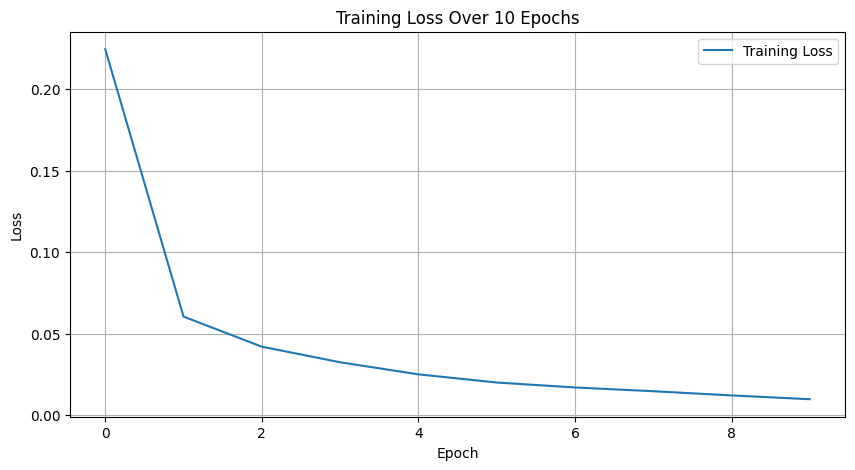

In [9]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss Over 10 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Testing your model

In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model: {100 * correct / total:.2f}%')

Accuracy of the model: 99.05%


## Saving the model

In [12]:
torch.save(model.state_dict(), 'model.pth')